In [1]:
print("strawberry")

strawberry


In [2]:
import torch
import numpy as np

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    dice_loss,
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary

### Set the seed

In [3]:
seed = 3407
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### define datasets and dataloaders

In [4]:
is3D = False

In [5]:
root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
#root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

In [6]:
# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ]

# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ] + [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]


domains = [
            ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
          ]

In [7]:
# augmentation definintion
def get_transforms(is_3D):
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        # RandomAffine(p=0.2, shear=(.1,3.)),
        # RandomAffine(p=0.2, degrees=5),
        RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))
        
        
        #RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
    ]
    if not is_3D:
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)
    else:
        transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)

In [8]:
# function to do train validate test split
test_proportion = 0.1
validation_proportion = 0.2

def train_val_test_split(dataset, val_prop, test_prop, seed):
    # I think the sklearn version might be prefereable for determinism and things
    # but that involves fiddling with the dataset implementation I think....
    size = len(dataset)
    test_size = int(test_prop*size) 
    val_size = int(val_prop*size)
    train_size = size - val_size - test_size
    train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    return train, val, test

In [9]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
if is3D:
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=True)) for domain in domains]
else:
    datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

In [10]:
len(train_dataset), len(val_dataset), len(test_dataset)

(8743, 2497, 1248)

In [11]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [12]:
# modified base version for p-unet

from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import get_conv_func
import torch.nn as nn
    
class HyperMapp3r_punet(HyperMapp3r):
    def __init__(self, dims=2,
                 in_channels=3,
                 out_channels=1,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=True,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 }):
        super().__init__(dims, in_channels, out_channels, encoder_features, decoder_features, softmax, up_res_blocks, block_params)
        
        # reconfigure the last layer thing
        conv_func = get_conv_func(dims, transpose=False)
        self.skip_final_convs = nn.ModuleList([
            conv_func(fs, decoder_features[-1], kernel_size=1)
            for fs in decoder_features[1:-1]
        ])
        
        self.num_out_features = decoder_features[-1] * 2 + encoder_features[0]
        
    def forward(self, x):
        skip_conns = []
        out = x
        
        # print("hypermappr3")
        # print("in shape: ", x.shape)
        # print("~~ENCODER~~")
        # encoder path
        for l in range(self.down_steps):
            out = self.encoder_down_blocks[l](out)
            out = self.encoder_resuq_blocks[l](out)
            # print("encoder group out shape", out.shape)
            
            if l != self.down_steps-1:
                skip_conns.append(out)
                
        # decoder path
        # print("~~DECODER~~")
        out = self.decoder_upsample_blocks[0](out)
        secondary_skip_conns = []
        for l in range(1, self.up_steps):
            # print("decoder group in: ", out.shape)
            #print("skip conn shape: ", skip_conns[-1].shape)
            out = torch.cat([out, skip_conns.pop()], dim=1)
            #print("post cat shape: ", out.shape)
            out = self.decoder_feature_blocks[l-1](out)
            out = self.decoder_upsample_blocks[l](out)
            
            if l >= 1:
                secondary_skip_conns.append(out)
        
        #print("final cat in shape: ", out.shape)
        out = torch.cat([out, skip_conns.pop()], dim=1)
        
        
        # combine secondary skips
        sk1 = self.skip_final_convs[0](secondary_skip_conns[0])
        #print("sk1 out shape pre interpolate: ", sk1.shape)
        sk1 = self.interpolate(sk1)
        #print("sk1 out shape post interpolate: ", sk1.shape)
        sk2 = self.skip_final_convs[1](secondary_skip_conns[1])
        #print("sk2 out shape pre interpolate: ", sk2.shape)
        sk2 = torch.add(sk1, sk2)
        #print("sk2 out shape post add: ", sk2.shape)
        sk2 = self.interpolate(sk2)
        #print("sk2 out shape post interpolate: ", sk2.shape)
        
        sk2 = self.interpolate(sk2)
        out = self.interpolate(out)
        
        return torch.cat([out, sk2], dim=1)

In [13]:
#hp = HyperMapp3r_punet()

In [14]:
# z = torch.randn(1, 3, 224, 160)
# hp(z).shape

In [15]:
#summary(hp, (1, 3, 224, 160))

In [16]:
# https://github.com/stefanknegt/Probabilistic-Unet-Pytorch/blob/master/utils.py
# ben took this code from above, its the p-Unet utils.

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

def truncated_normal_(tensor, mean=0, std=1):
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)

def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        #nn.init.normal_(m.weight, std=0.001)
        #nn.init.normal_(m.bias, std=0.001)
        truncated_normal_(m.bias, mean=0, std=0.001)

def init_weights_orthogonal_normal(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        nn.init.orthogonal_(m.weight)
        truncated_normal_(m.bias, mean=0, std=0.001)
        #nn.init.normal_(m.bias, std=0.001)

def l2_regularisation(m):
    l2_reg = None

    for W in m.parameters():
        if l2_reg is None:
            l2_reg = W.norm(2)
        else:
            l2_reg = l2_reg + W.norm(2)
    return l2_reg

def save_mask_prediction_example(mask, pred, iter):
    plt.imshow(pred[0,:,:],cmap='Greys')
    plt.savefig('images/'+str(iter)+"_prediction.png")
    plt.imshow(mask[0,:,:],cmap='Greys')
    plt.savefig('images/'+str(iter)+"_mask.png")

In [17]:
#ben took code from: https://github.com/stefanknegt/Probabilistic-Unet-Pytorch/blob/master/probabilistic_unet.py
# and replaced their unet with hypermapp3r

#from utils import init_weights,init_weights_orthogonal_normal, l2_regularisation
import torch.nn.functional as F
from torch.distributions import Normal, Independent, kl, LowRankMultivariateNormal

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Encoder(nn.Module):
    """
    A convolutional neural network, consisting of len(num_filters) times a block of no_convs_per_block convolutional layers,
    after each block a pooling operation is performed. And after each convolutional layer a non-linear (ReLU) activation function is applied.
    """
    def __init__(self, input_channels, num_filters, no_convs_per_block, initializers, padding=True, posterior=False):
        super(Encoder, self).__init__()
        self.contracting_path = nn.ModuleList()
        self.input_channels = input_channels
        self.num_filters = num_filters

        if posterior:
            #To accomodate for the mask that is concatenated at the channel axis, we increase the input_channels.
            self.input_channels += 1

        layers = []
        for i in range(len(self.num_filters)):
            """
            Determine input_dim and output_dim of conv layers in this block. The first layer is input x output,
            All the subsequent layers are output x output.
            """
            input_dim = self.input_channels if i == 0 else output_dim
            output_dim = num_filters[i]
            
            if i != 0:
                layers.append(nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True))
            
            layers.append(nn.Conv2d(input_dim, output_dim, kernel_size=3, padding=int(padding)))
            layers.append(nn.ReLU(inplace=True))

            for _ in range(no_convs_per_block-1):
                layers.append(nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=int(padding)))
                layers.append(nn.ReLU(inplace=True))

        self.layers = nn.Sequential(*layers)

        self.layers.apply(init_weights)

    def forward(self, input):
        output = self.layers(input)
        return output

class AxisAlignedConvGaussian(nn.Module):
    """
    A convolutional net that parametrizes a Gaussian distribution with axis aligned covariance matrix.
    """
    def __init__(self, input_channels, num_filters, no_convs_per_block, latent_dim, initializers, posterior=False):
        super(AxisAlignedConvGaussian, self).__init__()
        self.input_channels = input_channels
        self.channel_axis = 1
        self.num_filters = num_filters
        self.no_convs_per_block = no_convs_per_block
        self.latent_dim = latent_dim
        self.posterior = posterior
        self.rank = 10
        if self.posterior:
            self.name = 'Posterior'
        else:
            self.name = 'Prior'
        self.encoder = Encoder(self.input_channels, self.num_filters, self.no_convs_per_block, initializers, posterior=self.posterior)
        self.conv_layer = nn.Conv2d(num_filters[-1], 2 * self.latent_dim, (1,1), stride=1)
        self.cov_factor_layer = nn.Conv2d(num_filters[-1], self.latent_dim * self.rank, (1,1), stride=1)
        self.show_img = 0
        self.show_seg = 0
        self.show_concat = 0
        self.show_enc = 0
        self.sum_input = 0

        nn.init.kaiming_normal_(self.conv_layer.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.conv_layer.bias)

    def forward(self, input, segm=None):

        #If segmentation is not none, concatenate the mask to the channel axis of the input
        if segm is not None:
            self.show_img = input
            self.show_seg = segm
            input = torch.cat((input, segm), dim=1)
            self.show_concat = input
            self.sum_input = torch.sum(input)

        encoding = self.encoder(input)
        self.show_enc = encoding

        #We only want the mean of the resulting hxw image
        encoding = torch.mean(encoding, dim=2, keepdim=True)
        encoding = torch.mean(encoding, dim=3, keepdim=True)

        #Convert encoding to 2 x latent dim and split up for mu and log_sigma
        mu_log_sigma = self.conv_layer(encoding)
        cov_factor = self.cov_factor_layer(encoding)
        cov_factor = cov_factor.view((-1, self.rank, self.latent_dim))
        cov_factor = cov_factor.transpose(1,2)

        #We squeeze the second dimension twice, since otherwise it won't work when batch size is equal to 1
        mu_log_sigma = torch.squeeze(mu_log_sigma, dim=2)
        mu_log_sigma = torch.squeeze(mu_log_sigma, dim=2)

        mu = mu_log_sigma[:,:self.latent_dim]
        log_sigma = mu_log_sigma[:,self.latent_dim:]
        
        #sigma = log_sigma.exp()
        sigma = torch.nn.functional.softplus(log_sigma)
        
        mu = mu.clamp(-100,100)
        sigma = sigma.clamp(1e-29, 100)
        
        # print(mu.shape)
        # print(sigma.shape)

        #This is a multivariate normal with diagonal covariance matrix sigma
        #https://github.com/pytorch/pytorch/pull/11178
        # NOTE I have added the 1e-29 above
        dist = LowRankMultivariateNormal(loc=mu, cov_factor=cov_factor, cov_diag=sigma)

        return dist

class Fcomb(nn.Module):
    """
    A function composed of no_convs_fcomb times a 1x1 convolution that combines the sample taken from the latent space,
    and output of the UNet (the feature map) by concatenating them along their channel axis.
    """
    def __init__(self, num_filters, latent_dim, num_output_channels, num_classes, no_convs_fcomb, initializers, use_tile=True):
        super(Fcomb, self).__init__()
        self.num_channels = num_output_channels #output channels
        self.num_classes = num_classes
        self.channel_axis = 1
        self.spatial_axes = [2,3]
        self.num_filters = num_filters
        self.latent_dim = latent_dim
        self.use_tile = use_tile
        self.no_convs_fcomb = no_convs_fcomb 
        self.name = 'Fcomb'

        if self.use_tile:
            layers = []

            #Decoder of N x a 1x1 convolution followed by a ReLU activation function except for the last layer
            layers.append(nn.Conv2d(self.num_filters[0]+self.latent_dim, self.num_filters[1], kernel_size=1))
            layers.append(nn.ReLU(inplace=True))

            for _ in range(no_convs_fcomb-2):
                layers.append(nn.Conv2d(self.num_filters[1], self.num_filters[1], kernel_size=1))
                layers.append(nn.ReLU(inplace=True))

            self.layers = nn.Sequential(*layers)

            self.last_layer = nn.Conv2d(self.num_filters[1], self.num_classes, kernel_size=1)

            if initializers['w'] == 'orthogonal':
                self.layers.apply(init_weights_orthogonal_normal)
                self.last_layer.apply(init_weights_orthogonal_normal)
            else:
                self.layers.apply(init_weights)
                self.last_layer.apply(init_weights)

    def tile(self, a, dim, n_tile):
        """
        This function is taken form PyTorch forum and mimics the behavior of tf.tile.
        Source: https://discuss.pytorch.org/t/how-to-tile-a-tensor/13853/3
        """
        init_dim = a.size(dim)
        repeat_idx = [1] * a.dim()
        repeat_idx[dim] = n_tile
        a = a.repeat(*(repeat_idx))
        order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)])).to(device)
        return torch.index_select(a, dim, order_index)

    def forward(self, feature_map, z):
        """
        Z is batch_sizexlatent_dim and feature_map is batch_sizexno_channelsxHxW.
        So broadcast Z to batch_sizexlatent_dimxHxW. Behavior is exactly the same as tf.tile (verified)
        """
        #feature_map, sk2 = unet_out
        # print(feature_map.shape)
        # print(z.shape)
        if self.use_tile:
            z = torch.unsqueeze(z,2)
            z = self.tile(z, 2, feature_map.shape[self.spatial_axes[0]])
            z = torch.unsqueeze(z,3)
            z = self.tile(z, 3, feature_map.shape[self.spatial_axes[1]])
        # print(z.shape)
        
        # remove z from the model
        #z *= 0.

        #Concatenate the feature map (output of the UNet) and the sample 
        #taken from the latent space
        feature_map = torch.cat((feature_map, z), dim=self.channel_axis)
        # print(feature_map.shape)
        output = self.layers(feature_map)
        return self.last_layer(output)


class ProbabilisticUnet(nn.Module):
    """
    A probabilistic UNet (https://arxiv.org/abs/1806.05034) implementation.
    input_channels: the number of channels in the image (1 for greyscale and 3 for RGB)
    num_classes: the number of classes to predict
    num_filters: is a list consisint of the amount of filters layer
    latent_dim: dimension of the latent space
    no_cons_per_block: no convs per block in the (convolutional) encoder of prior and posterior
    """

    def __init__(self, input_channels=1, num_classes=1, num_filters=[16,64,128,192], latent_dim=6, no_convs_fcomb=4, beta=10.0):
        super(ProbabilisticUnet, self).__init__()
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.latent_dim = latent_dim
        self.no_convs_per_block = 3
        self.no_convs_fcomb = no_convs_fcomb
        self.initializers = {'w':'he_normal', 'b':'normal'}
        self.beta = beta
        self.z_prior_sample = 0        
        
        self.unet = HyperMapp3r_punet(dims=2,
                 in_channels=self.input_channels,
                 out_channels=self.num_classes,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=False,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 }
                   ).to(device)
        
        self.prior = AxisAlignedConvGaussian(self.input_channels, self.num_filters, self.no_convs_per_block, self.latent_dim,  self.initializers,).to(device)
        self.posterior = AxisAlignedConvGaussian(self.input_channels, self.num_filters, self.no_convs_per_block, self.latent_dim, self.initializers, posterior=True).to(device)
        self.fcomb = Fcomb([self.unet.num_out_features,self.num_filters[0]*2], self.latent_dim, self.input_channels, self.num_classes, self.no_convs_fcomb, {'w':'orthogonal', 'b':'normal'}, use_tile=True).to(device)

    def forward(self, patch, segm, training=True):
        """
        Construct prior latent space for patch and run patch through UNet,
        in case training is True also construct posterior latent space
        """
        if training:
            self.posterior_latent_space = self.posterior.forward(patch, segm)
        self.prior_latent_space = self.prior.forward(patch)
        self.unet_features = self.unet.forward(patch)

    def sample(self, testing=False):
        """
        Sample a segmentation by reconstructing from a prior sample
        and combining this with UNet features
        """
        if testing == False:
            z_prior = self.prior_latent_space.rsample()
            self.z_prior_sample = z_prior
        else:
            #You can choose whether you mean a sample or the mean here. For the GED it is important to take a sample.
            #z_prior = self.prior_latent_space.base_dist.loc 
            z_prior = self.prior_latent_space.sample()
            self.z_prior_sample = z_prior
        return self.fcomb.forward(self.unet_features,z_prior)


    def reconstruct(self, use_posterior_mean=False, calculate_posterior=False, z_posterior=None):
        """
        Reconstruct a segmentation from a posterior sample (decoding a posterior sample) and UNet feature map
        use_posterior_mean: use posterior_mean instead of sampling z_q
        calculate_posterior: use a provided sample or sample from posterior latent space
        """
        if use_posterior_mean:
            z_posterior = self.posterior_latent_space.loc
        else:
            if calculate_posterior:
                z_posterior = self.posterior_latent_space.rsample()
        return self.fcomb.forward(self.unet_features, z_posterior)

    def kl_divergence(self, analytic=True, calculate_posterior=False, z_posterior=None):
        """
        Calculate the KL divergence between the posterior and prior KL(Q||P)
        analytic: calculate KL analytically or via sampling from the posterior
        calculate_posterior: if we use samapling to approximate KL we can sample here or supply a sample
        """
        if analytic:
            #Neeed to add this to torch source code, see: https://github.com/pytorch/pytorch/issues/13545
            kl_div = kl.kl_divergence(self.posterior_latent_space, self.prior_latent_space)
        else:
            if calculate_posterior:
                z_posterior = self.posterior_latent_space.rsample()
            log_posterior_prob = self.posterior_latent_space.log_prob(z_posterior)
            log_prior_prob = self.prior_latent_space.log_prob(z_posterior)
            kl_div = log_posterior_prob - log_prior_prob
        return kl_div

    def elbo(self, segm, analytic_kl=True, reconstruct_posterior_mean=False):
        """
        Calculate the evidence lower bound of the log-likelihood of P(Y|X)
        """
        #weight = torch.Tensor([0.03/0.97, 0.97/0.03]).to(segm.device)
        weight=None
        #criterion = nn.BCEWithLogitsLoss(size_average = False, reduce=False, reduction=None)
        criterion = nn.CrossEntropyLoss(weight=weight, size_average = False, reduce=False, reduction=None)
        z_posterior = self.posterior_latent_space.rsample()
        
        self.kl = torch.mean(self.kl_divergence(analytic=analytic_kl, calculate_posterior=False, z_posterior=z_posterior))
        #self.kl = torch.mean(self.kl_divergence(analytic=False, calculate_posterior=True, z_posterior=z_posterior))
        # print(self.kl * self.beta)

        #Here we use the posterior sample sampled above
        self.reconstruction = self.reconstruct(use_posterior_mean=reconstruct_posterior_mean, calculate_posterior=False, z_posterior=z_posterior)
        
        reconstruction_loss = criterion(input=self.reconstruction, target=segm)
        
        # print(reconstruction_loss.sum())
        
        self.reconstruction_loss = torch.sum(reconstruction_loss)
        self.mean_reconstruction_loss = torch.mean(reconstruction_loss)

        #return -(self.reconstruction_loss + self.beta * self.kl)
        #return -self.reconstruction_loss
        return -self.reconstruction_loss, -self.beta * self.kl


In [18]:
#aag = AxisAlignedConvGaussian(input_channels=3, num_filters=[16, 32, 64, 128, 256], no_convs_per_block=2, latent_dim=28*20, initializers={'w':'he_normal', 'b':'normal'}, posterior=False)

In [19]:
#summary(aag, (1, 3, 224, 160))

In [20]:
# z = torch.randn((1, 3, 224, 160))
# v = aag(z)

### setup model

In [21]:
#del model_raw

In [21]:
in_channels = 3
out_channels = 1

model_raw = ProbabilisticUnet(input_channels=3, num_classes=2, num_filters=[16, 32, 64, 128, 256], latent_dim=14*20, no_convs_fcomb=4, beta=10.0)

In [22]:
#model_raw.load_state_dict(torch.load("finally_punet.ckpt"))

In [23]:
#summary(model_raw, input_data=[torch.randn(1, 3, 224, 160), torch.randn(1, 1, 224, 160)])

In [24]:
# z = torch.randn(1, 3, 224, 160)
# t = torch.randn(1, 2, 224, 160).argmax(dim=1).unsqueeze(1)
# with torch.no_grad():
#     model_raw.cuda()(z.cuda(), t.cuda())
#     s = model_raw.sample(True)

In [25]:
# model_raw.prior_latent_space.mean

In [26]:
# s.min(), s.max()

In [27]:
import pytorch_lightning as pl

import torch
import torch.nn as nn
import torch.nn.functional as F

class PUNetLitModelWrapper(pl.LightningModule):
    def __init__(self, model, loss=F.cross_entropy, logging_metric=None, optimizer_params={"lr":1e-3}, lr_scheduler_params={"step_size":30, "gamma":0.1}, is_uq_model=False,
                optimizer_constructor=None, lr_scheduler_constructor=None):
        super().__init__()
        self.model = model
        self.loss = loss
        self.logging_metric_train = logging_metric()
        self.logging_metric_val = logging_metric()
        self.optim_params = optimizer_params
        self.lr_scheduler_params = lr_scheduler_params
        self.is_uq_model = False
        self.optimizer_constructor = optimizer_constructor
        self.lr_scheduler_constructor = lr_scheduler_constructor

        
    def forward(self, x, y, **kwargs):
        return self.model(x, y, **kwargs)
    
    def configure_optimizers(self):
        # optimizer and schedulers go in the configure optimizers hook
        if self.optimizer_constructor:
            optimizer = self.optimizer_constructor(self.parameters(), **self.optim_params)
        else:
            optimizer = torch.optim.Adam(self.parameters(), **self.optim_params)
        
        if self.lr_scheduler_constructor:
            lr_scheduler = self.lr_scheduler_constructor(optimizer, **self.lr_scheduler_params)
        else:
            lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, **self.lr_scheduler_params)
        
        return [optimizer], [lr_scheduler]
    
    def training_step(self, batch, batch_idx):
        """
        lightning automates the training loop, 
        does epoch, back_tracking, optimizers and schedulers,
        and metric reduction.
        we just define how we want to process a single batch. 
        we can optionally pass optimizer_idx if we want to define multiple optimizers within the configure_optimizers
        hook, and I presume we can add our own parameters also to functions?
        """
        
        if self.is_uq_model:
            self.model.set_applyfunc(True)
        
        X, y = batch
        self(X, y.unsqueeze(1), training=True)
        # dice: This term is not part of the ELBO, so we are free to sample from
        # the prior network since this is used at test-time.
        #y_hat = self.model.sample(testing=False) # or I can use reconstruct to get samples from the posterior...
        y_hat = self.model.reconstruct(use_posterior_mean=False, calculate_posterior=True)
        loss = self.loss(self.model, y_hat, y)
        
        # metrics 
        if self.logging_metric_train:
            self.logging_metric_train(y_hat, y)
            self.log(f"train_metric", self.logging_metric_train, on_step=True, on_epoch=False, prog_bar=True)
        self.log("train_loss", loss)
        
        return loss
    
#     def training_epoch_end(self, outs):
#         self.log('train_metric_epoch', self.logging_metric_train.compute())
        
#     def validation_epoch_end(self, outs):
#         self.log('val_metric_epoch', self.logging_metric_val.compute())
    
    def validation_step(self, batch, batch_idx):
        """
        note: call trainer.validate() automatically loads the best checkpoint if checkpointing was enabled during fitting
        well yes I want to enable checkpointing but will deal with that later.
        also it does stuff like model.eval() and torch.no_grad() automatically which is nice.
        I will need a custom eval thing to do my dropout estimation but can solve that later too.
        """
        if self.is_uq_model:
            self.model.set_applyfunc(False)
        
        X, y = batch
        self(X, y.unsqueeze(1), training=True)
        y_hat = self.model.sample(testing=True)
        val_loss = self.loss(self.model, y_hat, y)
        
        if self.logging_metric_val:
            self.logging_metric_val(y_hat, y)
            self.log(f"val_metric", self.logging_metric_val, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_loss", val_loss)
        
    def test_step(self, batch, batch_idx):
        """
        we would need to directly call this function using the trainer
        """
        
        if self.is_uq_model:
            self.model.set_applyfunc(False)
        
        X, y = batch
        y_hat = self(X)
        test_loss = self.loss(y_hat, y)
        self.log("test_loss", test_loss)
        
    def predict_step(self, batch, batch_idx):
        """
        just for making predictions as opposed to collecting metrics etc
        note to use this, we just call .predict(dataloader) and it then automates the look
        these functions are for a single batch. Nice.
        """
        X, y = batch
        pred = self(X)
        return pred

In [28]:
#loss = dice_loss
#loss = torch.nn.CrossEntropyLoss(weight=torch.Tensor([0.968, 0.032]))
#loss = FocalLoss(gamma=1., reduction='mean', alpha=torch.Tensor([1-0.968, 1-0.032]))
#loss = log_cosh_dice_loss
#loss = TverskyLoss(beta=0.7)
#loss = FocalTverskyLoss(beta=0.7, gamma=0.8)

In [29]:
def punet_loss(net, pred, target):
    #elbo = net.elbo(target)
    xent, kl = net.elbo(target)
    reg_loss = l2_regularisation(net.posterior) + l2_regularisation(net.prior) + l2_regularisation(net.fcomb.layers)
    
    # print("elbo: ", elbo)
    
    # print("xent: " , xent)
    # print("kl: ", kl)
    # print("reg: ", reg_loss * 1e-5)
        
    dice = dice_loss(pred, target)
    
    if pred.max() > 1000 or pred.min() < -1000:
        print(pred.max(), pred.min())
        raise ValueError("to high")
    
    # print("dice: ", dice)
    
    #loss = -elbo * 1e-3 + 1e-5 * reg_loss + dice * 30
    #loss = -elbo * 1e-3 + 1e-5 * reg_loss + dice
    #loss = -elbo * 1e-3 + reg_loss * 1e-5 + dice
    #loss = dice #* 300
    loss = -xent *2e-4 -kl +1e-5*reg_loss + dice * 50
   # loss = dice * 50 - kl
    #loss = dice
    #loss = -kl +(1e-5*reg_loss) + dice * 50
    return loss

In [30]:
#optimizer_params={"lr":2e-4, "momentum":0.6}
optimizer_params={"lr":1e-5}
optimizer_params={"lr":1e-3}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[100,200], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

In [45]:
model = PUNetLitModelWrapper(model_raw, punet_loss, 
                                logging_metric=DiceLossMetric,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                is_uq_model=False,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               )
checkpoint = "multivariate_punet.ckpt"
model.model.load_state_dict(torch.load(checkpoint))

<All keys matched successfully>

In [32]:
checkpoint_dir = "./lightning_logs"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

accelerator="gpu"
devices=1
max_epochs=500
precision = 32

checkpoint_callback = ModelCheckpoint(checkpoint_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=500, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    strategy=strategy,
    precision=precision,
    default_root_dir=checkpoint_dir
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [33]:
#model.model.load_state_dict(torch.load("no_dice_punet.ckpt"))

### train

In [34]:
# the trick is to train without dice first it seems, and then add a dice in later. I really need to rebalance the cross entropy antually
# (and know that the determinici model on cross entropy needs to be summed not meaned)
#trainer.fit(model, train_dataloader, val_dataloader)

/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/s2208943/ipdis/Trustworthai-MRI-WMH/trustworthai/models/uq_models/initial_variants/p-unet/lightning_logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type              | Params
-----------------------------------------------------------
0 | model                | ProbabilisticUnet | 8.4 M 
1 | logging_metric_train | DiceLossMetric    | 0     
2 | logging_metric_val   | DiceLossMetric    | 0     
-----------------------------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.782    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 21.157


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.756 >= min_delta = 0.0. New best score: 18.401


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.928 >= min_delta = 0.0. New best score: 17.473


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.573 >= min_delta = 0.0. New best score: 16.900


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.038 >= min_delta = 0.0. New best score: 15.862


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.196 >= min_delta = 0.0. New best score: 15.666


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [36]:
# model = None
# model_raw = None
# train_dataloader = None
# val_dataloader = None
# s = None
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [46]:
trainer.validate(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            15.761670112609863
    val_metric_epoch        0.25113049149513245
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_metric_epoch': 0.25113049149513245, 'val_loss': 15.761670112609863}]

In [43]:
torch.save(model.model.state_dict(), "multivariate_punet.ckpt")
#model.model.load_state_dict(torch.load("finally_punet.ckpt"))

In [38]:
# okay so two parameters to vary now, are the latent dim size and the number of filters in the fcomb layer
# also note for the writeup how the dice can use test time samples, or not and I can do density estimation later
# also note how the architecture has been changed / where the upsamples are etc.

In [47]:
from tqdm import tqdm

In [48]:
posts = []
priors = []
with torch.no_grad():
    for x, y in tqdm(train_dataloader, ncols=150, position=0, leave=True):
        model(x, y.unsqueeze(1))
        posterior_sample = model.model.posterior_latent_space.rsample((10,))
        prior_sample = model.model.prior_latent_space.rsample((10,))
        
        posts.append(posterior_sample)
        priors.append(prior_sample)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 274/274 [07:28<00:00,  1.64s/it]


In [49]:
all_posts = torch.cat(posts, dim=1)
all_priors = torch.cat(priors, dim=1)

In [50]:
combined = torch.cat([all_posts, all_priors], dim=1)

In [51]:
means = torch.mean(combined, dim=0)

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [53]:
pca.fit(all_posts.mean(dim=0))

PCA(n_components=2)

In [54]:
pred_post_means = pca.transform(all_posts.mean(dim=0))
pred_prior_means = pca.transform(all_priors.mean(dim=0))

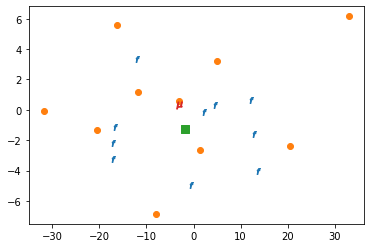

In [55]:
ind = 16
ind_post = pca.transform(all_posts[:,ind])
ind_prior = pca.transform(all_priors[:,ind])
plt.scatter(ind_post[:,0], ind_post[:,1], marker='$f$')
plt.scatter(ind_prior[:,0], ind_prior[:,1])
plt.scatter(pred_post_means[ind,0], pred_post_means[ind,1], marker='s', s=50)
plt.scatter(pred_prior_means[ind,0], pred_prior_means[ind,1], marker='$\mu$', s=50)

In [56]:
from sklearn.manifold import TSNE
fitted = TSNE(n_components=2, learning_rate='auto',
                init='random', perplexity=3).fit_transform(means)

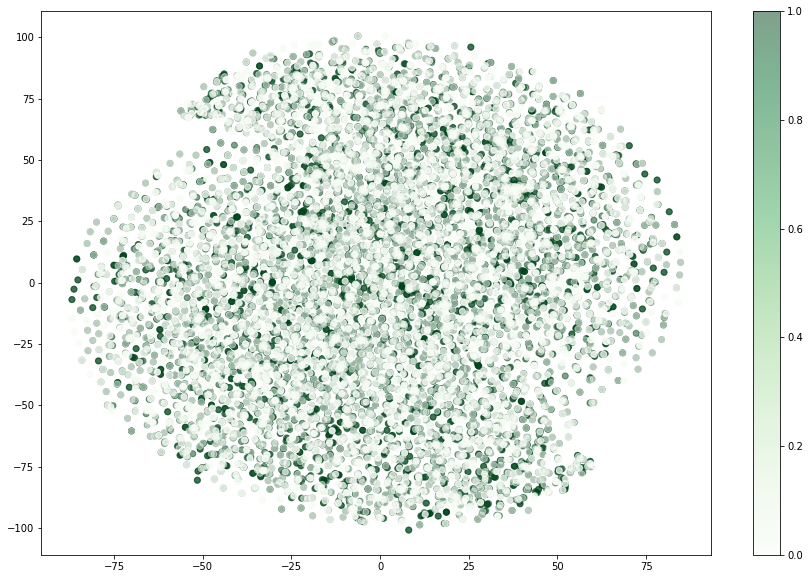

In [57]:
c = torch.zeros(fitted.shape[0])
c[0:fitted.shape[0]//2] = 1.

plt.figure(figsize=(15,10))
plt.scatter(fitted[:,0], fitted[:,1], c=c, alpha=0.5, cmap='Greens'); plt.colorbar()

In [58]:
fitted.shape[0]

17486

In [59]:
fitted[all_posts.shape[0]]

array([37.76149, 41.91373], dtype=float32)

In [60]:
torch.where(c==1)

(tensor([   0,    1,    2,  ..., 8740, 8741, 8742]),)

In [61]:
def entropy_map_from_samples(samples):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    probs = torch.nn.functional.softmax(samples, dim=2)
    pic = torch.mean(probs, dim=0)
    ent_map = torch.sum(-pic * torch.log(pic+1e-30), dim=1)
    
    return ent_map

In [62]:
from tqdm import tqdm

In [63]:
def get_samples(model, x, y):
    model.cuda()(x.cuda(), y.unsqueeze(1).cuda())
    samples = [model.model.sample(testing=True) for _ in range(14)]
    samples = torch.stack(samples, dim=0)
    return samples.cpu()

In [64]:
all_tps = []
all_tns = []
all_fps = []
all_fns = []

with torch.no_grad():
    for x, y in tqdm(val_dataloader, position=0, leave=True, ncols=150):
        samples = get_samples(model, x, y).cpu()
        ent = entropy_map_from_samples(samples).view([-1])
        mean = torch.mean(samples, dim=0)
        mean_class = mean.argmax(dim=1).view(-1)
        y_flat = y.view(-1)
        
        tp_loc = torch.where(torch.logical_and(y_flat == 1, mean_class == 1))[0]
        tn_loc = torch.where(torch.logical_and(torch.logical_and(y_flat == 0, mean_class == 0), x[:,1].reshape(-1) == 1))[0]
        fp_loc = torch.where(torch.logical_and(y_flat == 0, mean_class == 1))[0]
        fn_loc = torch.where(torch.logical_and(torch.logical_and(y_flat == 1, mean_class == 0), x[:,1].reshape(-1) == 1))[0]
        # print(tp_loc.shape)
        # print(ent.view(-1).shape)
        
        all_tps.append(ent[tp_loc])
        all_tns.append(ent[tn_loc])
        all_fps.append(ent[fp_loc])
        all_fns.append(ent[fn_loc])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:51<00:00,  1.42s/it]


In [65]:
tps = torch.cat(all_tps)
tns = torch.cat(all_tns)
fps = torch.cat(all_fps)
fns = torch.cat(all_fns)

In [66]:
tps.shape, tns.shape, fps.shape, fns.shape

(torch.Size([401248]),
 torch.Size([31227688]),
 torch.Size([103324]),
 torch.Size([170503]))

In [67]:
tps.mean(), tns.mean(), fps.mean(), fns.mean()

(tensor(0.1849), tensor(0.0045), tensor(0.3771), tensor(0.2180))

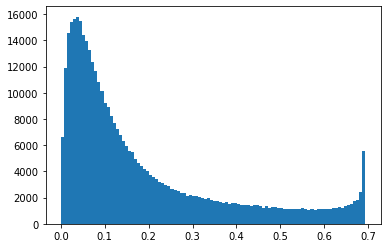

In [68]:
plt.hist(tps, bins=100);

In [69]:
#plt.hist(tns, bins=100);

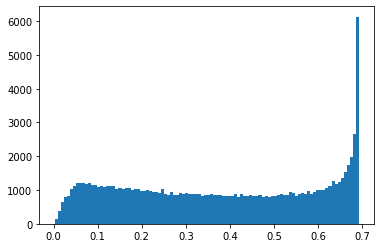

In [70]:
plt.hist(fps, bins=100);

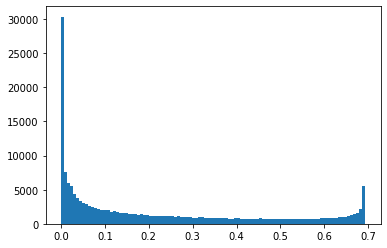

In [71]:
plt.hist(fns, bins=100);

### count the number of missing lesions per image.

In [72]:
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import kornia as K

def create_random_labels_map(classes: int) -> Dict[int, Tuple[int, int, int]]:
    labels_map: Dict[int, Tuple[int, int, int]] = {}
    for i in classes:
        labels_map[i] = torch.randint(0, 255, (3, ))
    labels_map[0] = torch.zeros(3)
    return labels_map

def labels_to_image(img_labels: torch.Tensor, labels_map: Dict[int, Tuple[int, int, int]]) -> torch.Tensor:
    """Function that given an image with labels ids and their pixels intrensity mapping, creates a RGB
    representation for visualisation purposes."""
    assert len(img_labels.shape) == 2, img_labels.shape
    H, W = img_labels.shape
    out = torch.empty(3, H, W, dtype=torch.uint8)
    for label_id, label_val in labels_map.items():
        mask = (img_labels == label_id)
        for i in range(3):
            out[i].masked_fill_(mask, label_val[i])
    return out

def show_components(img, labels):
    color_ids = torch.unique(labels)
    labels_map = create_random_labels_map(color_ids)
    labels_img = labels_to_image(labels, labels_map)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))
    
    # Showing Original Image
    ax1.imshow(img)
    ax1.axis("off")
    ax1.set_title("Orginal Image")
    
    #Showing Image after Component Labeling
    ax2.imshow(labels_img.permute(1,2,0).squeeze().numpy())
    ax2.axis('off')
    ax2.set_title("Component Labeling")

In [73]:
ys = []
conncomp_outs = []
ents_out = []
means_out = []
with torch.no_grad():
    for x, y in tqdm(val_dataloader, position=0, leave=True, ncols=150):
        labels_out = K.contrib.connected_components(y.unsqueeze(1).type(torch.float32), num_iterations=150)
        conncomp_outs.append(labels_out)
        ys.append(y)

        samples = get_samples(model, x, y).cpu()
        ents_out.append(entropy_map_from_samples(samples))
        means_out.append(torch.mean(samples, dim=0))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [03:13<00:00,  2.45s/it]


In [74]:
missing_lesion_size_ent = []
existing_lesion_size_ent = []
missing_lesion_size_mean = []
existing_lesion_size_mean = []
for batch in tqdm(range(len(ys)), position=0, leave=True, ncols=150):
    for i in range(ys[batch].shape[0]):
        conncomps = conncomp_outs[batch][i]
        ent = ents_out[batch][i]
        ent_thresh = (ent > 0.1).type(torch.long)
        mean = means_out[batch][i].argmax(dim=0).type(torch.long)
        
        ids = conncomps.unique()[1:]
        for idx in ids:
            cc = (conncomps == idx)
            size = torch.sum(cc)
            if torch.max(mean * cc) > 0:
                existing_lesion_size_mean.append(size)
            else:
                missing_lesion_size_mean.append(size)
            
            if torch.max(ent_thresh * cc) > 0:
                existing_lesion_size_ent.append(size)
            else:
                missing_lesion_size_ent.append(size)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:24<00:00,  3.23it/s]


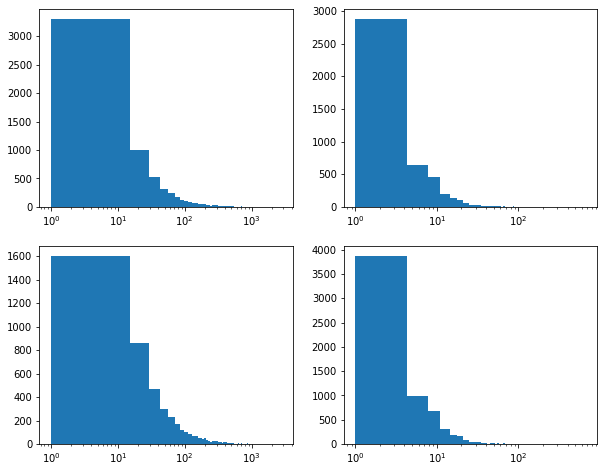

In [75]:
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
plt.hist(existing_lesion_size_ent, bins=200);
plt.xscale('log')
plt.subplot(2,2,2)
plt.hist(missing_lesion_size_ent, bins=200);
plt.xscale('log')

plt.subplot(2,2,3)
plt.hist(existing_lesion_size_mean, bins=200);
plt.xscale('log')
plt.subplot(2,2,4)
plt.hist(missing_lesion_size_mean, bins=200);
plt.xscale('log')

In [76]:
print("means")
torch.Tensor(existing_lesion_size_ent).mean(), torch.Tensor(missing_lesion_size_ent).mean(), torch.Tensor(existing_lesion_size_mean).mean(), torch.Tensor(missing_lesion_size_mean).mean()

means


(tensor(78.2315), tensor(7.9056), tensor(106.3430), tensor(8.2453))

In [77]:
def slice_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=0).argmax(dim=0)
    
    if torch.sum(y_hat) == 0 and torch.sum(y_true) == 0:
        return "n/a"
    
    numerator = torch.sum(2 * y_hat * y_true)
    denominator = torch.sum(y_hat + y_true)
    return numerator / (denominator + 1e-8)

In [78]:
slice_dices = []
with torch.no_grad():
    for x, y in tqdm(val_dataloader, position=0, ncols=150, leave=True):
        samples = get_samples(model, x, y).cpu()
        
        for i in range(y.shape[0]):
            ind_dices = []
            for s in samples[:,i]:
                ind_dices.append(slice_dice(s, y[i]))
            slice_dices.append(ind_dices)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [05:49<00:00,  4.42s/it]


In [79]:
# remove na images 
filtered_slice_dices = [x for x in slice_dices if 'n/a' not in x]

In [80]:
means = [torch.mean(torch.Tensor(x)) for x in filtered_slice_dices]

In [81]:
inds = torch.Tensor(means).sort()[1]

In [82]:
random_selection_inds = inds[torch.randint(0, len(inds), (200,)).sort()[0]]

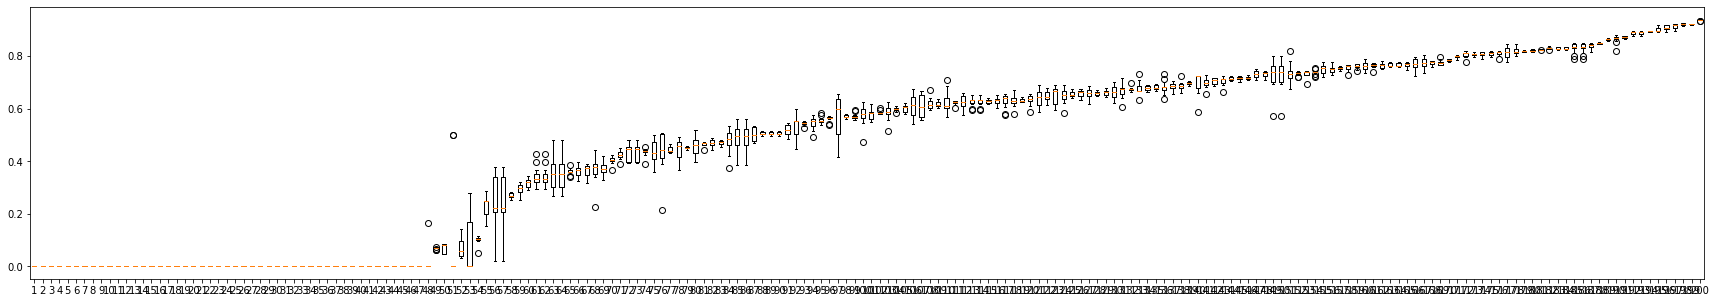

In [83]:
plt.figure(figsize=(30, 5))
plt.boxplot(torch.Tensor(filtered_slice_dices)[random_selection_inds]);

In [84]:
x, y, = next(iter(val_dataloader))

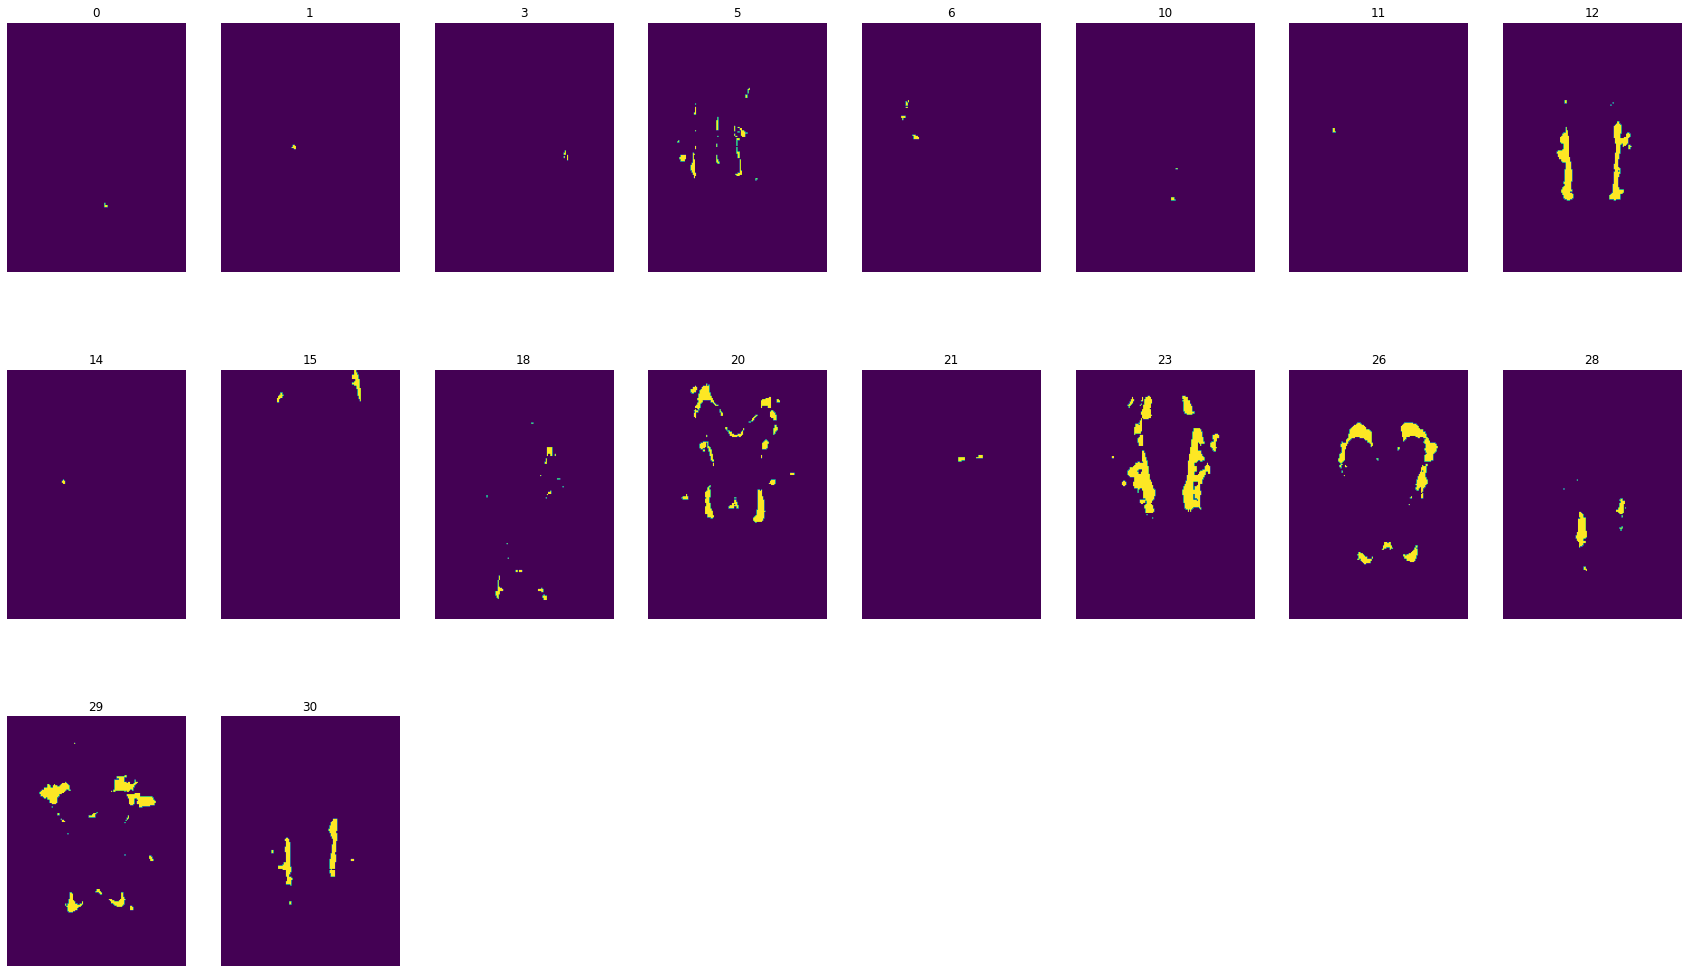

In [85]:
plt.figure(figsize=(30, 50))
count = 0
for i, img in enumerate(y):
    if torch.sum(img) > 0:
        plt.subplot(8, 8, count+1)
        plt.imshow(img); plt.axis('off');
        plt.title(i);
        count += 1
    

### look at calibrating the probability that a voxel is of class 1

In [86]:
from tqdm import tqdm

In [87]:
results = []
targets = []
ent_maps = []
dl = val_dataloader
with torch.no_grad():
    for x, y in tqdm(dl, total=len(dl), ncols=150, position=0, leave=True):
        samples = get_samples(model, x, y).cpu()
        results.append(samples)
        targets.append(y)
        ent_maps.append(entropy_map_from_samples(samples))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [02:30<00:00,  1.91s/it]


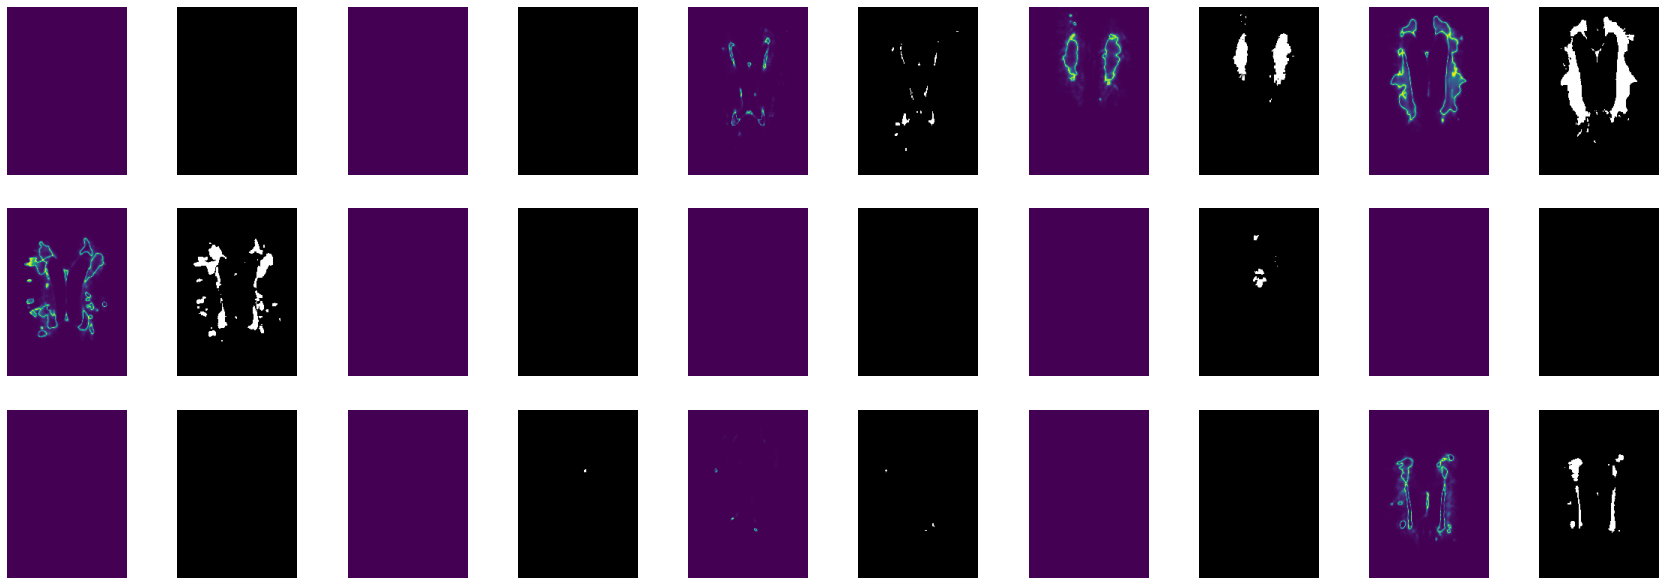

In [88]:
rand_inds_a = torch.randint(0, len(targets), (15,))
rand_inds_b = torch.randint(0, targets[0].shape[0], (15,))
plt.figure(figsize=(30, 10.5))
i = 0
for (ind_a, ind_b) in (zip(rand_inds_a, rand_inds_b)):
    plt.subplot(3, 10, i+1)
    batch = ent_maps[ind_a.item()]
    ind_b = ind_b.item()
    if batch.shape[0] <= ind_b:
        ind_b = batch.shape[0] - 1
    plt.imshow(batch[ind_b], cmap='viridis', vmin=0, vmax=0.7)
    plt.axis('off')
    
    plt.subplot(3, 10, i+2)
    plt.imshow(targets[ind_a][ind_b], cmap='gray')
    plt.axis('off')
    i += 2

In [89]:
rand_inds_a[6], rand_inds_b[6]

(tensor(71), tensor(17))

In [90]:
def place_in_bin(value):
    return torch.round(value, decimals=1)

In [91]:
def rolling_average(value, n, G):
    return value / n + ((n-1) / n) * G

def batch_rolling_average(values, n, G):
    """
    assumes all batches but the last batch are the same size
    """
    return values.sum() / (values.shape[0]*n) + ((n-1) / n) * G

In [92]:
# assess bin counts of p y = 1
bins = 10 + 1 # for the 0 bin
bin_batch_accuracies = [[] for b in range(bins)]
bin_batch_confidences = [[] for b in range(bins)]
bin_batch_sizes = [[] for b in range(bins)]
bin_counts = [0 for b in range(bins)]
for batch_idx in tqdm(range(len(targets)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
    batch_t = targets[batch_idx]
    batch_samples = results[batch_idx]
    
    if batch_t.shape[0] < 10:
        continue # skip last batch if it is very small.
    
    # get probabilities
    probs = torch.nn.functional.softmax(batch_samples, dim=2)
    p1s = probs[:,:,1]
    
    # split into bins
    bin_ids = place_in_bin(p1s)
    
    # compute counts
    for i in range(bins):
        is_in_bin = (bin_ids == (i / 10))
        # print(is_in_bin.shape)
        # print(batch_t.shape)
        
        # number of elements in each bin
        num_elem = torch.sum(is_in_bin).item()
        if num_elem == 0:
            print("zero")
        
        # number of predictions = to class 1
        c1_acc = batch_t.expand(p1s.shape)[is_in_bin].sum() / num_elem
        
        if torch.isnan(c1_acc):
            print("acc_nan")
        
        # average confidence of values in that bin
        c1_conf = p1s[is_in_bin].mean()
        
        if torch.isnan(c1_conf):
            print("conf_nan")
        
        bin_batch_accuracies[i].append(c1_acc)
        bin_batch_confidences[i].append(c1_conf)
        bin_batch_sizes[i].append(num_elem)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [02:12<00:00,  1.68s/it]


In [93]:
bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]


In [94]:
bin_accuracies

[0.0011883530532941222,
 0.23963530361652374,
 0.34394437074661255,
 0.39249658584594727,
 0.41710054874420166,
 0.4458252191543579,
 0.4741412103176117,
 0.5112255215644836,
 0.5734414458274841,
 0.6893374919891357,
 0.8954217433929443]

In [95]:
bin_confidences

[0.00016122410306707025,
 0.08684879541397095,
 0.19402064383029938,
 0.2960415482521057,
 0.3988329768180847,
 0.5005759596824646,
 0.6016050577163696,
 0.7030084729194641,
 0.805682361125946,
 0.9101972579956055,
 0.9832645058631897]

In [96]:
"""
looking at just the class one calibration is useful due to the extreme lack of class 1 in the image, this gives us a better idea of how the model is doing
and when optimizing calibration I should be optimizing this.
"""

'\nlooking at just the class one calibration is useful due to the extreme lack of class 1 in the image, this gives us a better idea of how the model is doing\nand when optimizing calibration I should be optimizing this.\n'

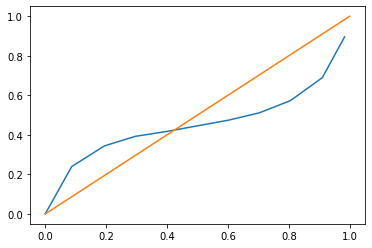

In [97]:
plt.plot(bin_confidences, bin_accuracies)
plt.plot([0,1],[0,1]);

In [98]:
exd = batch_t.expand(p1s.shape)

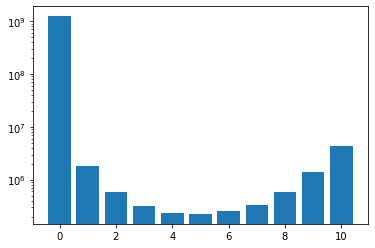

In [99]:
plt.bar([i for i in range(bins)], torch.Tensor(bin_sizes), align='center')
plt.yscale("log")

In [100]:
# now assess true calibration
bins = 10 + 1 # for the 0 bin
bin_batch_accuracies = [[] for b in range(bins)]
bin_batch_confidences = [[] for b in range(bins)]
bin_batch_sizes = [[] for b in range(bins)]
bin_counts = [0 for b in range(bins)]
for batch_idx in tqdm(range(len(targets)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
    batch_t = targets[batch_idx]
    batch_samples = results[batch_idx]
    
    if batch_t.shape[0] < 10:
        continue # skip last batch if it is very small.
    
    # get probabilities
    probs = torch.nn.functional.softmax(batch_samples, dim=2)
    pred_classes = probs.argmax(dim=2)
    confidences = probs.max(dim=2)[0]
    
    # split into bins
    bin_ids = place_in_bin(confidences)
    
    # compute counts
    for i in range(bins):
        is_in_bin = (bin_ids == (i / 10))
        # print(is_in_bin.shape)
        # print(batch_t.shape)
        
        # number of elements in each bin
        num_elem = torch.sum(is_in_bin).item()
        
        # number of predictions = to class 1
        c1_acc = (batch_t.expand(pred_classes.shape)[is_in_bin] == pred_classes[is_in_bin]).sum() / num_elem
        
        # average confidence of values in that bin
        c1_conf = confidences[is_in_bin].mean()
        
        bin_batch_accuracies[i].append(c1_acc)
        bin_batch_confidences[i].append(c1_conf)
        bin_batch_sizes[i].append(num_elem)
    # 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [06:50<00:00,  5.20s/it]


In [101]:
bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]

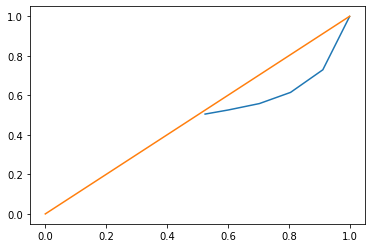

In [102]:
plt.plot(bin_confidences, bin_accuracies)
plt.plot([0,1],[0,1])

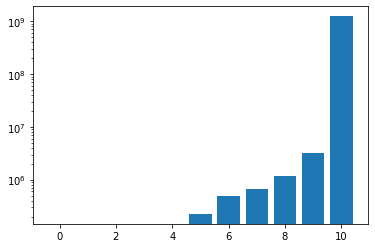

In [103]:
plt.bar([i for i in range(bins)], torch.Tensor(bin_sizes), align='center')
plt.yscale("log")

### Compute the PavPU metrics cause I'm not convinced my previous code in original ssn notebook was incorrect.

In [104]:
# I am going to do it per patch, but take the average accuracy per patch (perhaps I should qc average dice as well, best dice, worst dice.
uncetainty_thresholds = torch.arange(0, 0.7, 0.01)
accuracy_threshold = 0.9
window = 8
stride = 8
n_acs = [[] for i in range(len(uncetainty_thresholds))]
n_aus = [[] for i in range(len(uncetainty_thresholds))]
n_ics = [[] for i in range(len(uncetainty_thresholds))]
n_ius = [[] for i in range(len(uncetainty_thresholds))]

for batch_idx in tqdm(range(len(targets)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
    batch_t = targets[batch_idx]
    batch_samples = results[batch_idx]
    ent = ent_maps[batch_idx]
    
    # get probabilities
    probs = torch.nn.functional.softmax(batch_samples, dim=2)
    pred_classes = probs.argmax(dim=2)
    confidences = probs.max(dim=2)[0]
    
    # get average accuracy of each sample
    # or I could treat each patch of each sample as a separate thing but that is not what I am doing here.
    avg_accuracy = ((batch_t.expand(pred_classes.shape) == pred_classes) * 1.).mean(dim=0)
    
    # unroll predictions and targets and entropy
    t_unrolled = batch_t.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    accuracy_unrolled = avg_accuracy.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    ent_unrolled = ent.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    
    accurate_patches = accuracy_unrolled > 0.9
    
    # for each uncertainty threshold, compute the 4 numbers
    for i, uncert_t in enumerate(uncetainty_thresholds):
        uncertain_patches = ent_unrolled > uncert_t
        
        n_acs[i].append(torch.sum(torch.logical_and(accurate_patches, ~uncertain_patches)))
        n_aus[i].append(torch.sum(torch.logical_and(accurate_patches, uncertain_patches)))
        n_ics[i].append(torch.sum(torch.logical_and(~accurate_patches, ~uncertain_patches)))
        n_ius[i].append(torch.sum(torch.logical_and(~accurate_patches, uncertain_patches)))
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [04:49<00:00,  3.67s/it]


In [105]:
n_acs_t = [torch.Tensor(n_acs[i]).sum() for i in range(len(uncetainty_thresholds))]
n_aus_t = [torch.Tensor(n_aus[i]).sum() for i in range(len(uncetainty_thresholds))]
n_ics_t = [torch.Tensor(n_ics[i]).sum() for i in range(len(uncetainty_thresholds))]
n_ius_t = [torch.Tensor(n_ius[i]).sum() for i in range(len(uncetainty_thresholds))]

In [106]:
p_acs = [n_acs_t[i] / (n_acs_t[i] + n_ics_t[i]) for i in range(len(uncetainty_thresholds))]
p_aus = [n_ius_t[i] / (n_ius_t[i] + n_ics_t[i]) for i in range(len(uncetainty_thresholds))]
pavpu = [(n_acs_t[i] + n_ius_t[i]) / (n_ius_t[i] + n_ics_t[i] + n_aus_t[i] + n_acs_t[i]) for i in range(len(uncetainty_thresholds))]

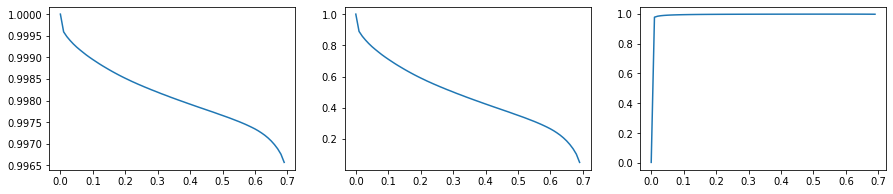

In [107]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(uncetainty_thresholds, p_acs)
plt.subplot(1,3,2)
plt.plot(uncetainty_thresholds, p_aus)
plt.subplot(1,3,3)
plt.plot(uncetainty_thresholds, pavpu)